Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Original data: (10000, 7)
Classification predictions: (2000, 13)
Regression predictions: (2000, 18)
Columns in pred_class: ['Year', 'Area_sq_km', 'NDVI', 'Population_Density', 'Temperature_Anomaly', 'Region_Arctic', 'Region_Asia', 'Region_Australia', 'Region_Europe', 'Region_North America', 'Region_South America', 'true_label', 'pred_label']
   Year    Area_sq_km      NDVI  Population_Density  Temperature_Anomaly  \
0  2021   2870.126602  0.288007           39.777644             0.369449   
1  2005   2422.211591  0.821682          122.488263             3.745379   
2  2022   5692.309145  0.807762          275.317625            -0.264231   
3  2017  10072.734997  0.272584          222.106777             2.549581   
4  2022   2998.540157  0.323415          135.157547             1.705776   

   Region_Arctic  Region_Asia  Region_Australia  Region_Europe  \
0   

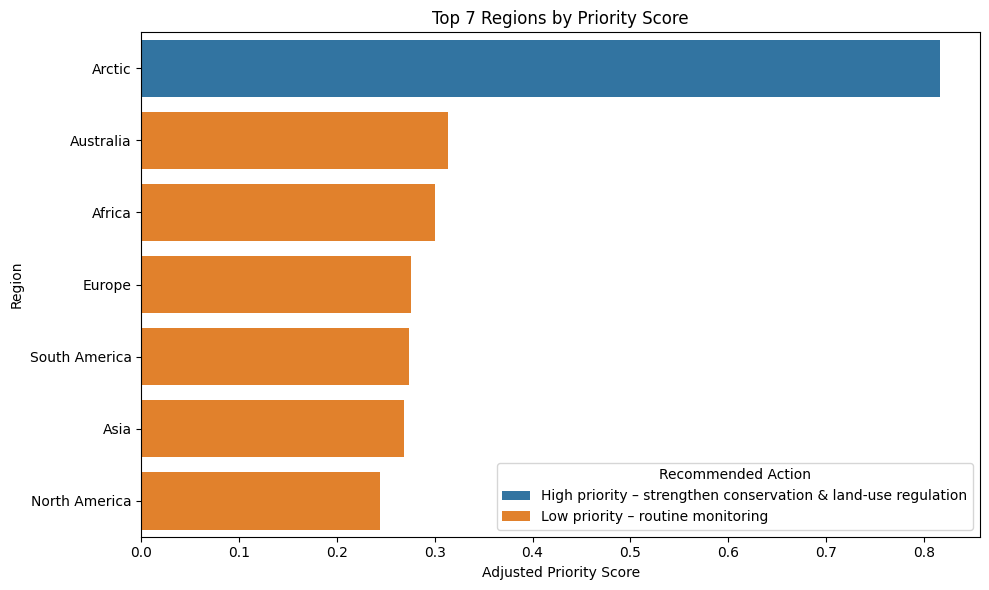

✅ Prescriptive analytics complete.
Check the CSV for full recommendations.


In [10]:
# ===============================================================
# Prescriptive Analytics for Global Earth Observation & Land Use Change
# ===============================================================

# ✅ Install dependencies
!pip install -q pandas numpy matplotlib seaborn geopandas shap scikit-learn xgboost joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# ===============================================================
# Load predictive outputs
# (Assumes you already ran predictive code and saved these CSVs)
# ===============================================================

# Mount Google Drive if needed
from google.colab import drive
drive.mount('/content/drive')


# Adjust paths as per your Drive
classification_preds_path = "/content/drive/MyDrive/predictions_classification.csv"
regression_preds_path     = "/content/drive/MyDrive/predictions_regression.csv"
original_data_path        = "/content/drive/MyDrive/Global 2_Land_Use_Change_10000.csv"

# Load datasets
df_orig = pd.read_csv(original_data_path, index_col=0, encoding="windows-1252").reset_index()
pred_class = pd.read_csv(classification_preds_path)
pred_reg   = pd.read_csv(regression_preds_path)

print("Original data:", df_orig.shape)
print("Classification predictions:", pred_class.shape)
print("Regression predictions:", pred_reg.shape)

# ===============================================================
# STEP 1: Prescriptive Scoring Framework
# ===============================================================
# We build a composite risk score for each region based on:
#  - Predicted land cover change (e.g., urban expansion)
#  - Decrease in NDVI (proxy for vegetation loss)
#  - Increase in Temperature_Anomaly
#  - Large land area under change

# Aggregate baseline stats from original data
agg = df_orig.groupby("Region").agg({
    "NDVI": "mean",
    "Temperature_Anomaly": "mean",
    "Area_sq_km": "sum",
    "Population_Density": "mean"
}).reset_index()

# Higher risk if NDVI is low, temperature anomaly high, urban growth predicted
# Normalize indicators to [0,1]
def normalize(series, invert=False):
    s = (series - series.min()) / (series.max() - series.min())
    return 1 - s if invert else s

agg["ndvi_risk"] = normalize(agg["NDVI"], invert=True)  # lower NDVI → higher risk
agg["temp_risk"] = normalize(agg["Temperature_Anomaly"]) # higher anomaly → higher risk
agg["area_pressure"] = normalize(agg["Area_sq_km"])
agg["pop_pressure"]  = normalize(agg["Population_Density"])

# Combine into composite score
agg["priority_score"] = (
      0.4 * agg["ndvi_risk"]
    + 0.3 * agg["temp_risk"]
    + 0.2 * agg["area_pressure"]
    + 0.1 * agg["pop_pressure"]
)

agg = agg.sort_values("priority_score", ascending=False)
agg.head()

# ===============================================================
# Debugging STEP
# ===============================================================
print("Columns in pred_class:", pred_class.columns.tolist())
print(pred_class.head())


# ===============================================================
# STEP 2: Link with Predictive Model Outputs (fixed for one-hot regions)
# ===============================================================

# 1) Identify dummy columns that encode Region
region_cols = [c for c in pred_class.columns if c.startswith("Region_")]
print("Detected region columns:", region_cols)

# 2) Convert one-hot encoding back into a single Region label
def get_region_from_dummies(row):
    for col in region_cols:
        if row[col]:                    # True or 1
            return col.replace("Region_", "")
    return "Unknown"

pred_class["Region"] = pred_class.apply(get_region_from_dummies, axis=1)

# 3) Now we can filter for urban-like predicted classes
urban_preds = pred_class[pred_class["pred_label"].str.contains("Urban", case=False)]

# 4) Group by Region to count frequency of Urban predictions
urban_risk_counts = (
    urban_preds
    .groupby("Region")
    .size()
    .reset_index(name="urban_pred_freq")
)

print("Urban risk counts per Region:\n", urban_risk_counts.head())

# ===============================================================
# STEP 2b: Merge aggregated stats with urban risk counts
# ===============================================================

# 'agg' is the table of baseline region stats & priority_score
# Make sure you have already run the block that builds 'agg' (Step 1)

prescriptive_df = agg.merge(urban_risk_counts, on="Region", how="left").fillna(0)

# Adjust priority score using urban risk frequency
def normalize(series, invert=False):
    s = (series - series.min()) / (series.max() - series.min()) if series.max() > series.min() else 0
    return 1 - s if invert else s

prescriptive_df["priority_score_adjusted"] = (
    prescriptive_df["priority_score"]
    + 0.2 * normalize(prescriptive_df["urban_pred_freq"])
)

prescriptive_df = prescriptive_df.sort_values("priority_score_adjusted", ascending=False)

print("Prescriptive DF created. Top rows:\n", prescriptive_df.head())

# ===============================================================
# STEP 3: Recommendations for Action
# ===============================================================
def recommend_action(row):
    if row["priority_score_adjusted"] > 0.75:
        return "High priority – strengthen conservation & land-use regulation"
    elif row["priority_score_adjusted"] > 0.5:
        return "Medium priority – monitor & plan mitigation"
    else:
        return "Low priority – routine monitoring"

prescriptive_df["recommended_action"] = prescriptive_df.apply(recommend_action, axis=1)

# Save to CSV for use in dashboards (e.g., Power BI / GIS)
prescriptive_path = "/content/drive/MyDrive/prescriptive_region_priority.csv"
prescriptive_df.to_csv(prescriptive_path, index=False)
print(f"✅ Prescriptive table saved to: {prescriptive_path}")

# ===============================================================
# STEP 4: Visualization
# ===============================================================
plt.figure(figsize=(10,6))
sns.barplot(data=prescriptive_df.head(15),
            x="priority_score_adjusted",
            y="Region",
            hue="recommended_action",
            dodge=False)
plt.xlabel("Adjusted Priority Score")
plt.ylabel("Region")
plt.title("Top 7 Regions by Priority Score")
plt.legend(title="Recommended Action")
plt.tight_layout()
plt.show()

print("✅ Prescriptive analytics complete.\nCheck the CSV for full recommendations.")
